# Ex08. 네이버 영화리뷰 감성분석 도전하기

## 0. 환경구축 및 필요한 패키지 import

In [1]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.initializers import Constant

import gensim
from gensim.models import KeyedVectors
from gensim.models.keyedvectors import Word2VecKeyedVectors

import konlpy
from konlpy.tag import Mecab

from collections import Counter

import warnings
warnings.filterwarnings('ignore')

## 1. 데이터 준비와 확인

In [3]:
# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print(train_data.shape)
print(test_data.shape)
train_data.head()

(150000, 3)
(50000, 3)


,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

In [4]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    ## 데이터의 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    #$ NaN 결측치 제거
    train_data = train_data.dropna(how = 'any') 
    test_data = test_data.dropna(how = 'any') 
    
    ## 한국어 토크나이저로 토큰화 및 불용어(Stopwords) 제거
    x_train = []
    for sentence in train_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_train.append(temp_x)

    x_test = []
    for sentence in test_data['document']:
        temp_x = tokenizer.morphs(sentence) # 토큰화
        temp_x = [word for word in temp_x if not word in stopwords] # 불용어 제거
        x_test.append(temp_x)
    
    ## 사전word_to_index 구성
    words = np.concatenate(x_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    ## 텍스트 스트링을 사전 인덱스 스트링으로 변환
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word]
            if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    x_train = list(map(wordlist_to_indexlist, x_train))
    x_test = list(map(wordlist_to_indexlist, x_test))
        
    ## x_train, y_train, x_test, y_test, word_to_index 리턴
    return x_train, np.array(list(train_data['label'])),\
        x_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data)

### word_to_index 딕셔너리를 이용하여 index_to_word 딕셔너리를 작성

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

### Encode, Decode 함수 작성

In [6]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 함
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word]
        if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index]
        if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  # [1:]: <BOS> 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공

### 데이터셋 내 문장 길이 분포

In [7]:
# 텍스트데이터 문장길이의 리스트를 생성
total_data_text = list(x_train) + list(x_test)

# 문장길이의 평균값, 최대값, 표준편차를 계산
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
 
print('평균 : ', np.mean(num_tokens))
print('최대 : ', np.max(num_tokens))
print('표준편차 : ', np.std(num_tokens))

평균 :  15.96940191154864
최대 :  116
표준편차 :  12.843571191092


### 적절한 최대 문장 길이 지정

In [8]:
# 전체 문장수의 90% 정도가 포함 되도록 한 문장당 최대길이를 정함
# maxlen_adj = sorted(num_tokens)[int(len(num_tokens) * 0.90)]
# print('Adjusted max length : ', maxlen_adj)

# 최대 길이를 (평균 + 2*표준편차)로 함  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen_adj = int(max_tokens)
print('Adjusted max length : ', maxlen_adj)
print('전체 문장의 {}%가 maxlen_adj 설정값 이내에 포함됩니다. '.format
      (round(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100, 2)))

Adjusted max length :  41
전체 문장의 93.43%가 maxlen_adj 설정값 이내에 포함됩니다. 


### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
x_train = keras.preprocessing.sequence.pad_sequences(x_train,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',  # pre가 post보다 유리
                                                    maxlen=maxlen_adj)

x_test = keras.preprocessing.sequence.pad_sequences(x_test,
                                                    value=word_to_index["<PAD>"],
                                                    padding='pre',
                                                    maxlen=maxlen_adj)

print(len(x_train))
print(len(x_test))

146182
49157


In [10]:
# 패딩처리가 제대로 되었는지 확인
total_data_text2 = list(x_train) + list(x_test)
num_tokens2 = [len(tokens) for tokens in total_data_text2]
num_tokens2 = np.array(num_tokens2)

print('평균 : ', np.mean(num_tokens2))
print('최대 : ', np.max(num_tokens2))
print('표준편차 : ', np.std(num_tokens2))

평균 :  41.0
최대 :  41
표준편차 :  0.0


## 4. 모델 구성 및 validation set 구성

### 4-0. Data를 train용과 validation용으로 분리

In [11]:
# 146182건 중 validation set 30000건 분리
x_val = x_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지
partial_x_train = x_train[30000:]  
partial_y_train = y_train[30000:]

print(len(x_val), len(y_val))
print(len(partial_y_train), len(partial_y_train)) 

30000 30000
116182 116182


### 4-1. RNN 모델

In [12]:
## Model 작성

vocab_size = 10000     # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

RNN_model = tf.keras.Sequential()
RNN_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
RNN_model.add(tf.keras.layers.LSTM(8))  # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용
                                        # LSTM state 벡터의 차원수는 8 (변경 가능)
RNN_model.add(tf.keras.layers.Dense(8, activation='relu'))
RNN_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
RNN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 9888      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 3,009,969
Trainable params: 3,009,969
Non-trainable params: 0
_________________________________________________________________


### 4-2. 1D CNN 모델

In [13]:
## Model 작성

vocab_size = 10000     # 어휘사전의 크기(10,000개의 단어)
word_vector_dim = 300  # 워드벡터의 차원수 (변경가능한 하이퍼파라미터)

CNN1D_model = tf.keras.Sequential()
CNN1D_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
CNN1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN1D_model.add(tf.keras.layers.MaxPooling1D(5))
CNN1D_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
CNN1D_model.add(tf.keras.layers.GlobalMaxPooling1D())
CNN1D_model.add(tf.keras.layers.Dense(8, activation='relu'))
CNN1D_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 1dim

CNN1D_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         3000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          33616     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

### 4-3. Transformer 모델

In [14]:
## Transformer 블록을 레이어로 구현

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [15]:
## Embedding layer 구현

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
## Model 작성

vocab_size = 10000  # 어휘사전의 크기(10,000개의 단어)
embed_dim = 128     # 각 토큰의 Embedding size
num_heads = 16      # 병렬로 어텐션 수행, 이때 병렬의 수
ff_dim = 64         # Transformer 내부에 존재하는 Feed Forward Network의 hidden layer size

inputs = layers.Input(shape=(maxlen_adj,))
embedding_layer = TokenAndPositionEmbedding(maxlen_adj, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
# x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
# x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

TRF_model = keras.Model(inputs=inputs, outputs=outputs)

## 5. 모델 훈련 개시

### 5-1 RNN 모델 훈련

In [17]:
## Model 학습

RNN_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 볼것 
RNN_history = RNN_model.fit(partial_x_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/10
227/227 [==============================] - 5s 9ms/step - loss: 0.4389 - accuracy: 0.8116 - val_loss: 0.3531 - val_accuracy: 0.8472
Epoch 2/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3207 - accuracy: 0.8651 - val_loss: 0.3355 - val_accuracy: 0.8544
Epoch 3/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2849 - accuracy: 0.8807 - val_loss: 0.3320 - val_accuracy: 0.8551
Epoch 4/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2569 - accuracy: 0.8925 - val_loss: 0.3458 - val_accuracy: 0.8537
Epoch 5/10
227/227 [==============================] - 2s 7ms/step - loss: 0.2310 - accuracy: 0.9043 - val_loss: 0.3525 - val_accuracy: 0.8562
Epoch 6/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2085 - accuracy: 0.9150 - val_loss: 0.3755 - val_accuracy: 0.8510
Epoch 7/10
227/227 [==============================] - 2s 7ms/step - loss: 0.1901 - accuracy: 0.9239 - val_loss: 0.3948 - val_accuracy: 0.8534
Epoch 

In [18]:
## 학습이 끝난 모델을 테스트셋으로 평가

results = RNN_model.evaluate(x_test,  y_test, verbose=2)
print(results) 

1537/1537 - 3s - loss: 0.4616 - accuracy: 0.8420
[0.4616437554359436, 0.8419756889343262]


### 5-2. 1D CNN 모델 훈련

In [19]:
## Model 학습

CNN1D_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 볼것 
CNN1D_history = CNN1D_model.fit(partial_x_train,
                                partial_y_train,
                                epochs=epochs,
                                batch_size=512,
                                validation_data=(x_val, y_val),
                                verbose=1)

Epoch 1/10
227/227 [==============================] - 4s 10ms/step - loss: 0.4454 - accuracy: 0.7862 - val_loss: 0.3392 - val_accuracy: 0.8528
Epoch 2/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2928 - accuracy: 0.8781 - val_loss: 0.3256 - val_accuracy: 0.8603
Epoch 3/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2180 - accuracy: 0.9146 - val_loss: 0.3571 - val_accuracy: 0.8537
Epoch 4/10
227/227 [==============================] - 2s 8ms/step - loss: 0.1405 - accuracy: 0.9492 - val_loss: 0.4185 - val_accuracy: 0.8486
Epoch 5/10
227/227 [==============================] - 2s 8ms/step - loss: 0.0853 - accuracy: 0.9716 - val_loss: 0.4952 - val_accuracy: 0.8488
Epoch 6/10
227/227 [==============================] - 2s 8ms/step - loss: 0.0547 - accuracy: 0.9822 - val_loss: 0.5860 - val_accuracy: 0.8411
Epoch 7/10
227/227 [==============================] - 2s 8ms/step - loss: 0.0371 - accuracy: 0.9882 - val_loss: 0.6757 - val_accuracy: 0.8407
Epoch

In [20]:
## 학습이 끝난 모델을 테스트셋으로 평가

results = CNN1D_model.evaluate(x_test,  y_test, verbose=2)
print(results) 

1537/1537 - 3s - loss: 0.9193 - accuracy: 0.8339
[0.919287383556366, 0.833919882774353]


### 5-3. Transformer 모델 훈련

In [21]:
## Model 훈련

TRF_model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 볼것 
TRF_history = TRF_model.fit(partial_x_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/10
227/227 [==============================] - 26s 109ms/step - loss: 0.4843 - accuracy: 0.7329 - val_loss: 0.3503 - val_accuracy: 0.8456
Epoch 2/10
227/227 [==============================] - 26s 113ms/step - loss: 0.3302 - accuracy: 0.8563 - val_loss: 0.3442 - val_accuracy: 0.8478
Epoch 3/10
227/227 [==============================] - 26s 113ms/step - loss: 0.3023 - accuracy: 0.8669 - val_loss: 0.3504 - val_accuracy: 0.8466
Epoch 4/10
227/227 [==============================] - 25s 111ms/step - loss: 0.2843 - accuracy: 0.8739 - val_loss: 0.3744 - val_accuracy: 0.8473
Epoch 5/10
227/227 [==============================] - 25s 112ms/step - loss: 0.2691 - accuracy: 0.8773 - val_loss: 0.3950 - val_accuracy: 0.8471
Epoch 6/10
227/227 [==============================] - 25s 112ms/step - loss: 0.2593 - accuracy: 0.8800 - val_loss: 0.4553 - val_accuracy: 0.8440
Epoch 7/10
227/227 [==============================] - 25s 111ms/step - loss: 0.2461 - accuracy: 0.8846 - val_loss: 0.4402 - val_ac

In [22]:
## 학습이 끝난 모델을 테스트셋으로 평가

results = TRF_model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 6s - loss: 0.4941 - accuracy: 0.8329
[0.4940645694732666, 0.832902729511261]


## 6. Loss, Accuracy 그래프 시각화

### 6-1. RNN 모델 그래프 시각화

In [23]:
RNN_history_dict = RNN_history.history
print(RNN_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


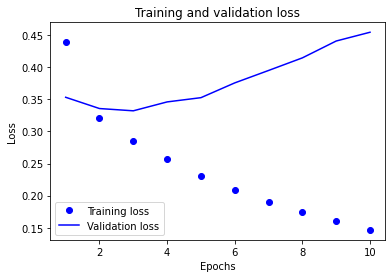

In [24]:
acc = RNN_history_dict['accuracy']
val_acc = RNN_history_dict['val_accuracy']
loss = RNN_history_dict['loss']
val_loss = RNN_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

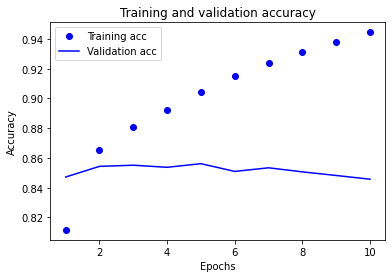

In [25]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 6-2. 1D CNN 모델 그래프 시각화

In [26]:
CNN1D_history_dict = CNN1D_history.history
print(CNN1D_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


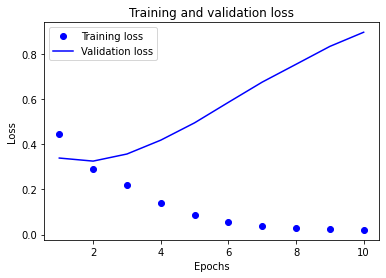

In [27]:
acc = CNN1D_history_dict['accuracy']
val_acc = CNN1D_history_dict['val_accuracy']
loss = CNN1D_history_dict['loss']
val_loss = CNN1D_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

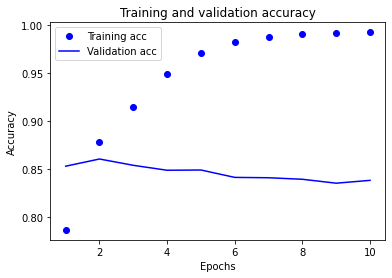

In [28]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 6-3. Transformer 모델 그래프 시각화

In [29]:
TRF_history_dict = TRF_history.history
print(TRF_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


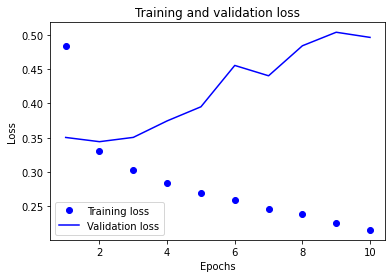

In [30]:
acc = TRF_history_dict['accuracy']
val_acc = TRF_history_dict['val_accuracy']
loss = TRF_history_dict['loss']
val_loss = TRF_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

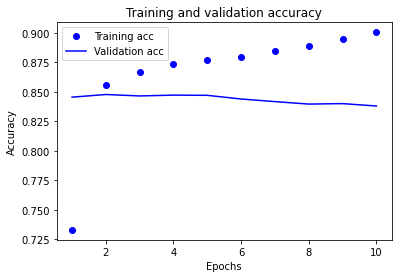

In [31]:
plt.clf()  # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 7. 학습된 Embedding 레이어 분석

### 7-1. 자체학습 임베딩

In [32]:
# 학습한 Embedding 파라미터를 저장한 폴더 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/'

#### 7-1-1. RNN Model

In [33]:
embedding_layer = RNN_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 300)


In [34]:
word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
f = open(word2vec_file_path+'RNN_word2vec.txt', 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = RNN_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [35]:
vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path+'RNN_word2vec.txt', binary=False)
vectors.similar_by_word("사랑")

[('삶', 0.8464392423629761),
 ('즐거웠', 0.8329818248748779),
 ('완벽', 0.830302357673645),
 ('깊', 0.8210005760192871),
 ('DVD', 0.8138769268989563),
 ('한석규', 0.8111339211463928),
 ('바가지', 0.8079726099967957),
 ('통쾌', 0.8073918223381042),
 ('만점', 0.80498868227005),
 ('ㅠㅠㅠㅠㅠ', 0.7985312342643738)]

#### 7-1-2. 1D CNN Model

In [36]:
embedding_layer = CNN1D_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 300)


In [37]:
word_vector_dim = 300
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
f = open(word2vec_file_path+'CNN1D_word2vec.txt', 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = CNN1D_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [38]:
vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path+'CNN1D_word2vec.txt', binary=False)
vectors.similar_by_word("사랑")

[('디테일', 0.5568735003471375),
 ('자무시', 0.5524102449417114),
 ('맴도', 0.5510973930358887),
 ('완소', 0.5465418696403503),
 ('슬퍼요', 0.5458773970603943),
 ('1997', 0.5424361228942871),
 ('먹먹', 0.5400255918502808),
 ('주옥같', 0.5347081422805786),
 ('따스', 0.5312296748161316),
 ('이제서야', 0.5302199721336365)]

#### 7-1-3. Transformer Model

In [39]:
word_vector_dim = 128  # 모델 작성 시 지정한 embed_dim
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
f = open(word2vec_file_path+'TRF_word2vec.txt', 'w')
# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = TRF_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [40]:
vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path+'TRF_word2vec.txt', binary=False)
vectors.similar_by_word("사랑")

[('재미있', 0.9022637605667114),
 ('수작', 0.8906489014625549),
 ('짱', 0.8792860507965088),
 ('감사', 0.8751798272132874),
 ('눈물', 0.8732578158378601),
 ('걸작', 0.8730859160423279),
 ('푹', 0.8718368411064148),
 ('돌파', 0.871342658996582),
 ('이동욱', 0.8712431788444519),
 ('굳', 0.870996356010437)]

In [41]:
vectors.similar_by_word("컴퓨터")

[('끝판', 0.7103278040885925),
 ('노튼', 0.7046157717704773),
 ('놀라움', 0.6968554854393005),
 ('·', 0.6925457715988159),
 ('무상', 0.6910058856010437),
 ('스럽', 0.6623117923736572),
 ('영화제', 0.6606156229972839),
 ('새롭', 0.658432126045227),
 ('매튜', 0.6581020355224609),
 ('..!!!', 0.6569390892982483)]

### 7-2. 사전학습 임베딩

In [42]:
word2vec_path = \
    os.getenv('HOME')+'/aiffel/sentiment_classification/data/GoogleNews-vectors-negative300.bin.gz'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True, limit=None)  # 300만개 로딩
vector = word2vec['computer']
vector  # 무려 300dim의 워드 벡터입니다.

array([ 1.07421875e-01, -2.01171875e-01,  1.23046875e-01,  2.11914062e-01,
       -9.13085938e-02,  2.16796875e-01, -1.31835938e-01,  8.30078125e-02,
        2.02148438e-01,  4.78515625e-02,  3.66210938e-02, -2.45361328e-02,
        2.39257812e-02, -1.60156250e-01, -2.61230469e-02,  9.71679688e-02,
       -6.34765625e-02,  1.84570312e-01,  1.70898438e-01, -1.63085938e-01,
       -1.09375000e-01,  1.49414062e-01, -4.65393066e-04,  9.61914062e-02,
        1.68945312e-01,  2.60925293e-03,  8.93554688e-02,  6.49414062e-02,
        3.56445312e-02, -6.93359375e-02, -1.46484375e-01, -1.21093750e-01,
       -2.27539062e-01,  2.45361328e-02, -1.24511719e-01, -3.18359375e-01,
       -2.20703125e-01,  1.30859375e-01,  3.66210938e-02, -3.63769531e-02,
       -1.13281250e-01,  1.95312500e-01,  9.76562500e-02,  1.26953125e-01,
        6.59179688e-02,  6.93359375e-02,  1.02539062e-02,  1.75781250e-01,
       -1.68945312e-01,  1.21307373e-03, -2.98828125e-01, -1.15234375e-01,
        5.66406250e-02, -

In [43]:
word2vec.similar_by_word("love")

[('loved', 0.6907791495323181),
 ('adore', 0.6816873550415039),
 ('loves', 0.661863386631012),
 ('passion', 0.6100708842277527),
 ('hate', 0.600395679473877),
 ('loving', 0.5886635780334473),
 ('Ilove', 0.5702950954437256),
 ('affection', 0.5664337873458862),
 ('undying_love', 0.5547304749488831),
 ('absolutely_adore', 0.5536840558052063)]

In [44]:
word2vec.similar_by_word("computer")

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.647333562374115),
 ('com_puter', 0.6082080006599426),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617720484733582),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618730545044),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

#### 사전학습 임베딩의 단어 유사도가 자체학습 임베딩에 비하여 월등히 우수함을 알 수 있다.

### 7-3. Word2Vector 임베딩을 적용한 학습

In [45]:
vocab_size = 10000     # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)
# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

In [46]:
## 모델 구성

EMBD_model = tf.keras.Sequential()
EMBD_model.add(tf.keras.layers.Embedding(vocab_size, 
                            word_vector_dim, 
                            embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 활용
                            input_length=maxlen_adj, 
                            trainable=True))  # trainable을 True로 주면 Fine-tuning
EMBD_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
EMBD_model.add(tf.keras.layers.MaxPooling1D(5))
EMBD_model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
EMBD_model.add(tf.keras.layers.GlobalMaxPooling1D())
EMBD_model.add(tf.keras.layers.Dense(8, activation='relu'))
EMBD_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 
EMBD_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 16)            33616     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [47]:
## Model 학습

EMBD_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs=10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 변경
EMBD_history = EMBD_model.fit(partial_x_train,
                              partial_y_train,
                              epochs=epochs,
                              batch_size=512,
                              validation_data=(x_val, y_val),
                              verbose=1)

Epoch 1/10
227/227 [==============================] - 3s 9ms/step - loss: 0.6924 - accuracy: 0.5065 - val_loss: 0.6759 - val_accuracy: 0.5143
Epoch 2/10
227/227 [==============================] - 2s 8ms/step - loss: 0.5036 - accuracy: 0.7570 - val_loss: 0.3813 - val_accuracy: 0.8319
Epoch 3/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3494 - accuracy: 0.8509 - val_loss: 0.3523 - val_accuracy: 0.8485
Epoch 4/10
227/227 [==============================] - 2s 8ms/step - loss: 0.3050 - accuracy: 0.8740 - val_loss: 0.3473 - val_accuracy: 0.8512
Epoch 5/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2780 - accuracy: 0.8874 - val_loss: 0.3810 - val_accuracy: 0.8333
Epoch 6/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2516 - accuracy: 0.9007 - val_loss: 0.3750 - val_accuracy: 0.8423
Epoch 7/10
227/227 [==============================] - 2s 8ms/step - loss: 0.2259 - accuracy: 0.9135 - val_loss: 0.3827 - val_accuracy: 0.8418
Epoch 

In [48]:
## 테스트셋을 통한 모델 평가

results = EMBD_model.evaluate(x_test,  y_test, verbose=2)
print(results)

1537/1537 - 3s - loss: 0.4567 - accuracy: 0.8311
[0.4566746652126312, 0.8311328887939453]


### 7-4. Loss, Accuracy 그래프 시각화

In [49]:
EMBD_history_dict = EMBD_history.history
print(EMBD_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


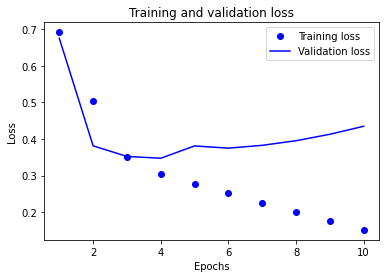

In [50]:
acc = EMBD_history_dict['accuracy']
val_acc = EMBD_history_dict['val_accuracy']
loss = EMBD_history_dict['loss']
val_loss = EMBD_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

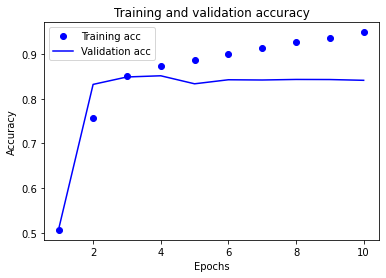

In [51]:
plt.clf()  # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 7-5. 학습된 Embedding 레이어 분석

In [52]:
embedding_layer = EMBD_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)  # shape: (vocab_size, embedding_dim)

(10000, 300)


In [53]:
# 학습한 Embedding 파라미터를 파일에 저장 
word_vector_dim = 300
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/Embed_word2vec.txt'

# 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 저장
vectors = EMBD_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [54]:
# 임베딩 파라미터 확인
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("love")

[('♡', 0.7005444169044495),
 ('great', 0.63471519947052),
 ('very', 0.6088501214981079),
 ('good', 0.6052876114845276),
 ('best', 0.5929969549179077),
 ('♥', 0.5883083343505859),
 ('we', 0.5150853991508484),
 ('It', 0.4842403829097748),
 ('me', 0.4824000597000122),
 ('top', 0.48140767216682434)]

In [55]:
word2vec.similar_by_word("computer")

[('computers', 0.7979379892349243),
 ('laptop', 0.6640493273735046),
 ('laptop_computer', 0.6548868417739868),
 ('Computer', 0.647333562374115),
 ('com_puter', 0.6082080006599426),
 ('technician_Leonard_Luchko', 0.5662748217582703),
 ('mainframes_minicomputers', 0.5617720484733582),
 ('laptop_computers', 0.5585449934005737),
 ('PC', 0.5539618730545044),
 ('maker_Dell_DELL.O', 0.5519254207611084)]

#### Word2Vector를 활용한 자체학습 임베딩의 경우 단어의 유사도가 사전학습에 못지 않음을 알 수 있다.

## 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선
Word2Vec 임베딩은 8-10 에서 학습한 내용을 적용함

In [56]:
word2vec_file_path = os.getenv('HOME')+'/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['행복']
vector

array([ 3.6889346 , -3.2576382 , -2.6349437 , -0.11572476,  0.58762413,
       -0.16673814,  0.9697601 ,  0.27856505, -0.92762107,  2.241611  ,
        2.8666036 ,  0.458429  , -2.007293  ,  1.9756018 ,  2.9543707 ,
        0.17504454, -1.0210766 ,  0.6119247 ,  0.9948327 , -2.6716058 ,
       -3.3571372 ,  2.8433375 , -0.64212775,  0.2906057 ,  0.66890335,
        0.6893659 ,  0.19818003,  0.8735505 ,  2.6482987 , -0.188396  ,
       -1.997001  , -2.1050427 , -3.5394318 ,  0.57390505,  0.09716978,
        1.7057031 , -2.3355813 ,  1.624613  ,  0.27012238,  1.6980075 ,
       -1.5318449 , -0.59364384, -1.3710705 ,  3.4411204 ,  1.1825829 ,
        2.1342924 ,  2.8075287 ,  2.1308038 ,  2.7114947 , -0.3305534 ,
        2.3805175 , -0.04170982,  1.2907016 , -2.8457797 , -0.91359496,
       -3.9291334 ,  0.3625686 , -1.7948011 ,  1.1991819 ,  3.9061072 ,
        4.1032424 , -0.88820845,  1.1552868 , -3.5846636 , -1.7109742 ,
       -2.9963055 , -0.5262824 , -0.2760053 , -1.5208707 , -0.90

In [57]:
vocab_size = 10000     # 어휘 사전의 크기 (10,000개의 단어)
word_vector_dim = 300  # 워드 벡터의 차원수 (변경가능한 하이퍼파라미터)

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 모델 구성

In [58]:
# 모델 구성
kor_model = tf.keras.Sequential()
kor_model.add(tf.keras.layers.Embedding(vocab_size, 
                            word_vector_dim, 
                            embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩 활용
                            input_length=maxlen_adj, 
                            trainable=True))   # trainable을 True로 주면 Fine-tuning
kor_model.add(tf.keras.layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3))
kor_model.add(tf.keras.layers.Dense(64, activation='relu'))
kor_model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

kor_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 300)           3000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_10 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 3,227,969
Trainable params: 3,227,969
Non-trainable params: 0
_________________________________________________________________


### 모델 훈련

In [59]:
kor_model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
              
epochs = 10  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 볼것 
kor_history = kor_model.fit(partial_x_train,
                            partial_y_train,
                            epochs=epochs,
                            batch_size=512,
                            validation_data=(x_val, y_val),
                            verbose=1)

Epoch 1/10
227/227 [==============================] - 46s 191ms/step - loss: 0.5355 - accuracy: 0.7125 - val_loss: 0.3802 - val_accuracy: 0.8319
Epoch 2/10
227/227 [==============================] - 43s 190ms/step - loss: 0.3824 - accuracy: 0.8293 - val_loss: 0.3644 - val_accuracy: 0.8372
Epoch 3/10
227/227 [==============================] - 43s 189ms/step - loss: 0.3435 - accuracy: 0.8509 - val_loss: 0.3351 - val_accuracy: 0.8546
Epoch 4/10
227/227 [==============================] - 43s 191ms/step - loss: 0.3229 - accuracy: 0.8619 - val_loss: 0.3391 - val_accuracy: 0.8505
Epoch 5/10
227/227 [==============================] - 43s 188ms/step - loss: 0.3087 - accuracy: 0.8689 - val_loss: 0.3279 - val_accuracy: 0.8562
Epoch 6/10
227/227 [==============================] - 43s 187ms/step - loss: 0.2937 - accuracy: 0.8762 - val_loss: 0.3293 - val_accuracy: 0.8578
Epoch 7/10
227/227 [==============================] - 42s 187ms/step - loss: 0.2812 - accuracy: 0.8824 - val_loss: 0.3274 - val_ac

### 테스트셋을 통한 모델 평가

In [60]:
results = kor_model.evaluate(x_test, y_test, verbose=2)
print(results)

1537/1537 - 20s - loss: 0.3427 - accuracy: 0.8572
[0.3426516652107239, 0.8572126030921936]


### Loss, Accuracy 그래프 시각화

In [61]:
kor_history_dict = kor_history.history
print(kor_history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


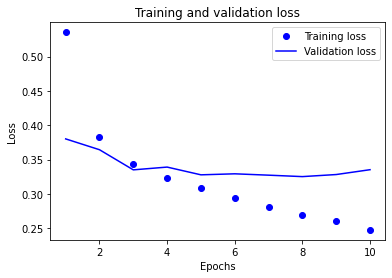

In [62]:
acc = kor_history_dict['accuracy']
val_acc = kor_history_dict['val_accuracy']
loss = kor_history_dict['loss']
val_loss = kor_history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# bo는 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

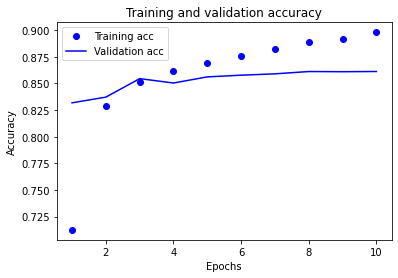

In [63]:
plt.clf()  # 그림을 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회고
<<이번 프로젝트에서 어려웠던 점>>

Transformer model이 요즘 대세라고 하여 구글링을 해 적용해보았으나 Accuracy가 타 모델에 비하여 높지 않았다. 여러가지 변형을 시도해 보았으나 이해하기가 어려워 에러만 발생하고 실패했다.

<<프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점>>

1. RNN, CNN 모델보다 우수한 Transformer model이 있다는것을 알게 되었다.
2. LSTM document를 읽어보고 변경 가능한 각 파라미터에 대해 알게되었다,

<<루브릭 평가 지표를 맞추기 위해 시도한 것들>>

한국어 Word2Vec 임베딩에 8-10에서 학습한 모델을 그대로 적용해 보았으나 Test Accuracy가 83.38%로 목표 85%에 미치지 못하였다.

개선을 위하여 시도한 방법:

1. CNN Model을 그나마 Accuracy가 높았던 RNN Model로 변경 --> 84.48%로 개선됨
2. LSTM Units 수 128, Dense Units 수 64일때 --> 84.61%로 개선됨
3. 훈련 진행과정을 볼때 Overfitting이 되는것으로 생각되어 dropout=0.3, recurrent_dropout=0.3 적용 --> 85.72% 달성

<<만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정>>

평가지표를 달성함.

<<자기 다짐>>

Transformer 모델을 별도로 공부하여 완전히 이해할 수 있도록 노력하겠다.
